In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
from matplotlib.gridspec import GridSpec
from scipy.interpolate import griddata, LinearNDInterpolator, NearestNDInterpolator

%matplotlib inline

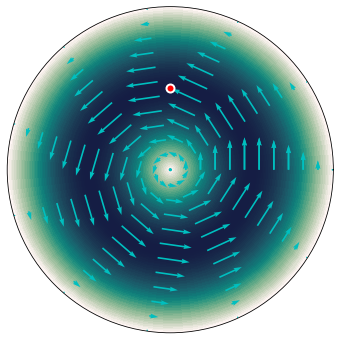

In [2]:
N = 100
s = 9

r = np.linspace(0.,2.,N)
theta = np.linspace(0.,2.*np.pi,N)
rg,tg = np.meshgrid(r,theta)
sg = np.sin(rg * np.pi/2.)
ug = sg * np.cos(tg + np.pi/2.)
vg = sg * np.sin(tg + np.pi/2.)

#contours = np.hstack([np.arange(0.,0.9,0.05),np.linspace(0.9,1.,20)])
contours = np.linspace(0.,1.,51)

fig  = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111,polar=True)
plt.grid(False)
ax.set_rticks([])
ax.set_thetagrids([])
pc = ax.pcolormesh(tg,rg,sg,vmin=0.,vmax=1.,cmap=cm.tempo,shading='auto')
ax.quiver(tg[::s,::s],rg[::s,::s],ug[::s,::s],vg[::s,::s],angles="uv",scale=10.,color='c')
ax.scatter(np.pi/2.,1.,facecolor='r',edgecolor='w',lw=2,s=64)
#plt.colorbar(pc,orientation='vertical',shrink=0.7,ticks=np.linspace(0.,1.,11))

plt.savefig('./steady_field.png',dpi=450)

C:\Users\hauke\AppData\Local\Temp/ipykernel_33624/1680731228.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax.pcolormesh(xg,yg,sg,vmin=0.,vmax=1.,cmap=cm.tempo,shading='auto')


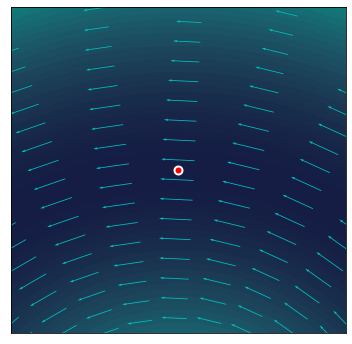

In [3]:
N = 100
s = 3
b = 0.5

r = np.linspace(0.,2.,N)
theta = np.linspace(0.,2.*np.pi,N)
rg,tg = np.meshgrid(r,theta)
xg = rg*np.cos(tg)
yg = rg*np.sin(tg)
sg = np.sin(rg * np.pi/2.)
ug = sg * np.cos(tg + np.pi/2.)
vg = sg * np.sin(tg + np.pi/2.)

#contours = np.hstack([np.arange(0.,0.9,0.05),np.linspace(0.9,1.,20)])
contours = np.linspace(0.,1.,51)

fig  = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111,polar=False)
#plt.grid(False)
#ax.set_rticks([])
#ax.set_thetagrids([])
pc = ax.pcolormesh(xg,yg,sg,vmin=0.,vmax=1.,cmap=cm.tempo,shading='auto')
ax.quiver(xg[::s,::s],yg[::s,::s],ug[::s,::s],vg[::s,::s],angles="uv",scale=10.,color='c')
ax.scatter(0.,1.,facecolor='r',edgecolor='w',lw=2,s=64)
#plt.colorbar(pc,orientation='vertical',shrink=0.7,ticks=np.linspace(0.,1.,11))
#ax.set_rlim(0.8,1.2)
#ax.set_thetalim(np.pi/2. - np.pi/12.,np.pi/2. + np.pi/12.)
ax.set_xlim(-b,b)
ax.set_xticks([])
ax.set_ylim(1. - b,1. + b)
ax.set_yticks([])

plt.savefig('./steady_field_zoom.png',dpi=450)

In [3]:
def generate_forcing(opt,N):
    """script to generate grid and forcing fields for Blanken et al 2023 paper

    Parameters
    ----------
    opt: dict
        dictionary of run-specific namelist parameters
    N: int
        number of time steps in the simulation

    Returns
    -------
    grid: tuple
        3-element tuple containing the time, x, and y grid needed to describe the velocity field
        all elements are 3-dimensional numpy arrays of floats (time, x, and y)
    u: numpy array of floats
        3-dimensional numpy array containing x-direction velocities
    v: numpy array of floats
        3-dimensional numpy array containing y-direction velocities
    spd: numpy array of floats
        3-dimensional numpy array containing speeds
    """

    #generate space and time grids based on namelist parameters 'extent' and 'res', as well as number of time steps
    tg,xg,yg = np.meshgrid(np.linspace(0.,2.*np.pi,N),
                           np.arange(-opt['extent'],opt['extent'] + opt['res'] / 2.,opt['res']),
                           np.arange(-opt['extent'],opt['extent'] + opt['res'] / 2.,opt['res']),indexing='ij')
    #convert space grid to polar coordinates
    r = np.sqrt(xg**2. + yg**2.)
    theta = np.arctan2(yg,xg) + np.pi/2.

    if opt['force_type'] == 'constant':
        #steady forcing in Blanken et al 2023
        spd = np.sin(np.pi * r / opt['extent']) * opt['amp']
    elif opt['force_type'] == 'wave':
        #unsteady forcing in Blanken et al 2023
        spd = np.cos(tg + 0.5) * np.sin(np.pi * r / opt['extent']) * opt['amp']
    elif opt['force_type'] == 'pulse':
        #square-wave pulse forcing orbiting a circular velocity field, not used in Blanken et al 2023
        #TODO: this forcing type doesn't yet seem to work correctly. Figure out why that is.
        T = 1. * np.pi
        tau = np.pi / 4.
        spd = np.array([[[opt['amp']*tau/T + (2.*opt['amp']/np.pi) * np.sum([np.sin(np.pi*n*tau/T + k) * np.cos(2.*np.pi*n*tg[k,j,i]/T + k) / n for n in range(1,51)]) for i in range(tg.shape[2])] for j in range(tg.shape[1])] for k in range(tg.shape[0])]) * np.sin(np.pi * r / opt['extent']) * opt['amp']

    #convert forcing to u,v-coordinates
    u = spd * np.cos(theta)
    v = spd * np.sin(theta)

    return (tg,xg,yg),u,v,spd

opt = {
    'extent':2.,
    'res':0.1,
    'amp':1.,
    'force_type':'constant'
}
N = 2

grid,u,v,spd = generate_forcing(opt,N)

C:\Users\hauke\AppData\Local\Temp/ipykernel_24108/1363306920.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(grid[1][0,:,:],grid[2][0,:,:],spd[0,:,:],cmap=cm.balance,alpha=0.5,vmin=-1.,vmax=1.)


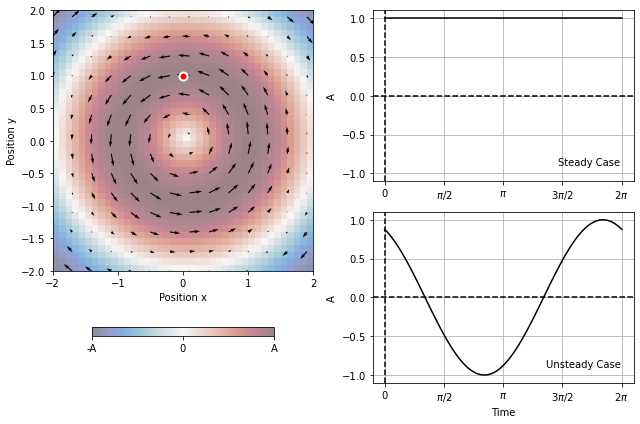

In [10]:
N = 100
s = 3

r = np.linspace(0.,2.,N)
theta = np.linspace(0.,2.*np.pi,N)
rg,tg = np.meshgrid(r,theta)
sg = np.sin(rg * np.pi/2.)
ug = sg * np.cos(tg + np.pi/2.)
vg = sg * np.sin(tg + np.pi/2.)

#contours = np.hstack([np.arange(0.,0.9,0.05),np.linspace(0.9,1.,20)])
contours = np.linspace(0.,1.,51)

fig  = plt.figure(figsize=(9,6))
gs = GridSpec(2,2)
ax = fig.add_subplot(gs[:,0],polar=False)
plt.grid(False)
ax.set_xlabel('Position x')
ax.set_ylabel('Position y')
pc = ax.pcolormesh(grid[1][0,:,:],grid[2][0,:,:],spd[0,:,:],cmap=cm.balance,alpha=0.5,vmin=-1.,vmax=1.)
ax.quiver(grid[1][0,::s,::s],grid[2][0,::s,::s],u[0,::s,::s],v[0,::s,::s],scale=20.)
ax.scatter(0.,1.,facecolor='r',edgecolor='w',lw=2,s=64)
cb = plt.colorbar(pc,orientation='horizontal',shrink=0.7,ticks=[-1.,0.,1.])
cb.set_ticklabels(['-A','0','A'])

time = np.linspace(0.,2.*np.pi,100)
axu = fig.add_subplot(gs[1,1])
axu.plot(time,np.cos(time+0.5),color='k')
axu.set_xlabel('Time')
axu.set_xticks(np.linspace(0.,2.*np.pi,5))
axu.set_xticklabels(['0','$\pi/2$','$\pi$','$3\pi/2$','$2\pi$'])
axu.text(0.95,0.08,'Unsteady Case',ha='right',va='bottom',transform=axu.transAxes)

axs = fig.add_subplot(gs[0,1],sharex=axu)
axs.plot([0.,2.*np.pi],[1.,1.],color='k')
axs.text(0.95,0.08,'Steady Case',ha='right',va='bottom',transform=axs.transAxes)

for ax in [axs,axu]:
    ax.grid(which='both')
    ax.axhline(0.,color='k',ls='--')
    ax.axvline(0.,color='k',ls='--')
    ax.set_ylabel('A')
    ax.set_ylim(-1.1,1.1)

plt.tight_layout()
plt.savefig('D:/iCloudDrive/Thesis/Figures/fig1_velocity_fields.png',dpi=450,bbox_inches='tight')
plt.savefig('D:/iCloudDrive/Thesis/Figures/fig1_velocity_fields.svg',bbox_inches='tight')

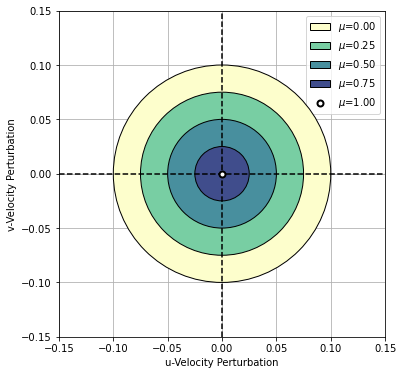

In [39]:
from matplotlib.patches import Circle

noise = [0.1,0.075,0.05,0.025]

fig,ax = plt.subplots(figsize=(6,6))
ax.set_xlim(-0.15,0.15)
ax.set_ylim(-0.15,0.15)
ax.axhline(0.,color='k',ls='--',zorder=1001)
ax.axvline(0.,color='k',ls='--',zorder=1001)
ax.set_aspect('equal')
ax.grid(which='both')

for ind,n in enumerate(noise):
    circ = plt.Circle((0.,0.),n,facecolor=cm.deep_r(n/noise[0]),edgecolor='k',zorder=1000,label=r'$\mu$=%.2f'%(ind/len(noise)))
    ax.add_patch(circ)

ax.scatter(0.,0.,marker='o',facecolor='w',edgecolor='k',lw=2,label=r'$\mu$=1.00',zorder=1002)
ax.set_ylabel('v-Velocity Perturbation')
ax.set_xlabel('u-Velocity Perturbation')
    
ax.legend(loc=1)

plt.savefig('D:/iCloudDrive/Thesis/Figures/fig2_membershipFunction.png',dpi=450,bbox_inches='tight')
plt.savefig('D:/iCloudDrive/Thesis/Figures/fig2_membershipFunction.svg',bbox_inches='tight')

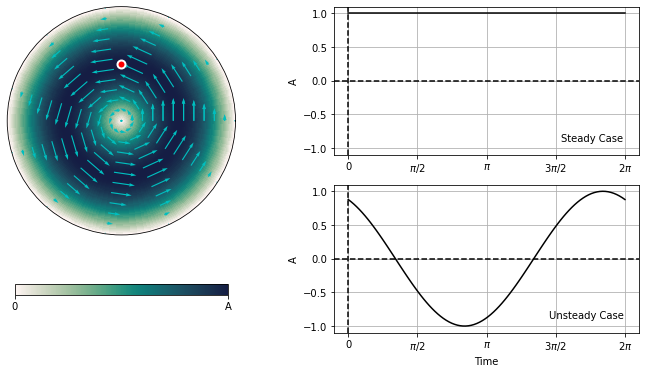

In [5]:
N = 100
s = 9

r = np.linspace(0.,2.,N)
theta = np.linspace(0.,2.*np.pi,N)
rg,tg = np.meshgrid(r,theta)
sg = np.sin(rg * np.pi/2.)
ug = sg * np.cos(tg + np.pi/2.)
vg = sg * np.sin(tg + np.pi/2.)

#contours = np.hstack([np.arange(0.,0.9,0.05),np.linspace(0.9,1.,20)])
contours = np.linspace(0.,1.,51)

fig  = plt.figure(figsize=(12,6))
gs = GridSpec(2,2)
ax = fig.add_subplot(gs[:,0],polar=True)
plt.grid(False)
ax.set_rticks([])
ax.set_thetagrids([])
pc = ax.pcolormesh(tg,rg,sg,vmin=0.,vmax=1.,cmap=cm.tempo,shading='auto')
ax.quiver(tg[::s,::s],rg[::s,::s],ug[::s,::s],vg[::s,::s],angles="uv",scale=10.,color='c')
ax.scatter(np.pi/2.,1.,facecolor='r',edgecolor='w',lw=2,s=64)
cb = plt.colorbar(pc,orientation='horizontal',shrink=0.7,ticks=[0.,1.])
cb.set_ticklabels(['0','A'])

time = np.linspace(0.,2.*np.pi,100)
axu = fig.add_subplot(gs[1,1])
axu.plot(time,np.cos(time+0.5),color='k')
axu.set_xlabel('Time')
axu.set_xticks(np.linspace(0.,2.*np.pi,5))
axu.set_xticklabels(['0','$\pi/2$','$\pi$','$3\pi/2$','$2\pi$'])
axu.text(0.95,0.08,'Unsteady Case',ha='right',va='bottom',transform=axu.transAxes)

axs = fig.add_subplot(gs[0,1],sharex=axu)
axs.plot([0.,2.*np.pi],[1.,1.],color='k')
axs.text(0.95,0.08,'Steady Case',ha='right',va='bottom',transform=axs.transAxes)

for ax in [axs,axu]:
    ax.grid(which='both')
    ax.axhline(0.,color='k',ls='--')
    ax.axvline(0.,color='k',ls='--')
    ax.set_ylabel('A')
    ax.set_ylim(-1.1,1.1)

plt.savefig('./fig1_velocity_fields.png',dpi=450)

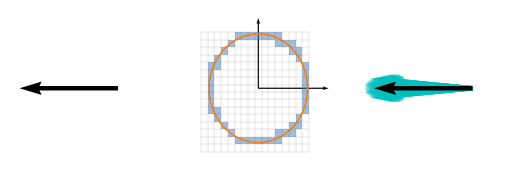

In [94]:
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].axis("off")
ax[0].quiver(0.,0.,-1.,0.,color='k',scale=1.5,width=0.03)
ax[0].set_xlim(-1.5,0.5)

ax[1].axis("off")
ax1lim = 1.5
theta = np.linspace(0.,2.*np.pi,100)
ax[1].plot(np.cos(theta),np.sin(theta),color='tab:orange')
ax[1].quiver(0.,0.,1.,0.,color='k',scale=2.1,width=0.008)
ax[1].quiver(0.,0.,0.,1.,color='k',scale=2.1,width=0.008)
ax[1].set_xlim(-ax1lim,ax1lim)
ax[1].set_ylim(-ax1lim,ax1lim)
grex = 1.1
for a in np.linspace(-grex,grex,17)-grex/16.:
    ax[1].plot(np.linspace(a,a,2),np.linspace(-grex,grex,2)-grex/16.,color='k',alpha=0.5,lw=0.2)
    ax[1].plot(np.linspace(-grex,grex,2)-grex/16.,np.linspace(a,a,2),color='k',alpha=0.5,lw=0.2)
xg,yg = np.meshgrid(np.linspace(-grex,grex,17),np.linspace(-grex,grex,17))
zg = np.zeros_like(xg)
for th in theta:
    d = np.sqrt((xg - np.cos(th))**2. + (yg - np.sin(th))**2.)
    j,i = np.where(d == d.min())
    zg[j[0],i[0]] = 1.
ax[1].pcolormesh(xg,yg,np.ma.masked_where(zg == 0.,zg),vmin=0.,vmax=2.,cmap=cm.ice_r,alpha=0.5,shading='nearest')

fuzzvel_fac = 0.1
ax[2].axis("off")
j,i = np.where(zg == 1.)
for jj,ii in zip(j,i):
    ax[2].quiver(0.,0.,-1. + fuzzvel_fac * xg[jj,ii],0. + fuzzvel_fac * yg[jj,ii],color='c',scale=1.5,width=0.03,alpha=0.5)
ax[2].quiver(0.,0.,-1.,0.,color='k',scale=1.5,width=0.03)
ax[2].set_xlim(-1.5,0.5)

plt.savefig('./fuzzified_vector_npg.svg')

#crisp vector should be a grid showing the crisp field around the start point
#fuzzy vector, right panel, should be a collection of grids showing the possible fields with the constant offsets

C:\Users\hauke\AppData\Local\Temp/ipykernel_33624/2616786204.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xg,yg,np.ma.masked_where(zg == 0.,zg),cmap=cm.amp,vmin=0.,vmax=1.)


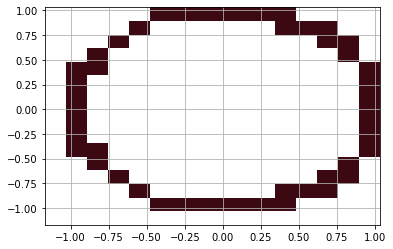

In [73]:
plt.pcolormesh(xg,yg,np.ma.masked_where(zg == 0.,zg),cmap=cm.amp,vmin=0.,vmax=1.)
plt.grid(which='both')

In [2]:
def generate_forcing(opt,N):
        """script to generate grid and forcing fields for Blanken et al 2023 paper

        Parameters
        ----------
        opt: dict
            dictionary of run-specific namelist parameters
        N: int
            number of time steps in the simulation

        Returns
        -------
        grid: tuple
            3-element tuple containing the time, x, and y grid needed to describe the velocity field
            all elements are 3-dimensional numpy arrays of floats (time, x, and y)
        u: numpy array of floats
            3-dimensional numpy array containing x-direction velocities
        v: numpy array of floats
            3-dimensional numpy array containing y-direction velocities
        spd: numpy array of floats
            3-dimensional numpy array containing speeds
        """

        #generate space and time grids based on namelist parameters 'extent' and 'res', as well as number of time steps
        tg,xg,yg = np.meshgrid(np.linspace(0.,2.*np.pi,N),
                               np.arange(-opt['extent'],opt['extent'] + opt['res'] / 2.,opt['res']),
                               np.arange(-opt['extent'],opt['extent'] + opt['res'] / 2.,opt['res']),indexing='ij')
        #convert space grid to polar coordinates
        r = np.sqrt(xg**2. + yg**2.)
        theta = np.arctan2(yg,xg) + np.pi/2.

        if opt['force_type'] == 'constant':
            #steady forcing in Blanken et al 2023
            spd = np.sin(np.pi * r / opt['extent']) * opt['amp']
        elif opt['force_type'] == 'wave':
            #unsteady forcing in Blanken et al 2023
            spd = np.cos(tg + 0.5) * np.sin(np.pi * r / opt['extent']) * opt['amp']
        elif opt['force_type'] == 'pulse':
            #square-wave pulse forcing orbiting a circular velocity field, not used in Blanken et al 2023
            #TODO: this forcing type doesn't yet seem to work correctly. Figure out why that is.
            T = 1. * np.pi
            tau = np.pi / 4.
            spd = np.array([[[opt['amp']*tau/T + (2.*opt['amp']/np.pi) * np.sum([np.sin(np.pi*n*tau/T + k) * np.cos(2.*np.pi*n*tg[k,j,i]/T + k) / n for n in range(1,51)]) for i in range(tg.shape[2])] for j in range(tg.shape[1])] for k in range(tg.shape[0])]) * np.sin(np.pi * r / opt['extent']) * opt['amp']

        #convert forcing to u,v-coordinates
        u = spd * np.cos(theta)
        v = spd * np.sin(theta)

        return (tg,xg,yg),u,v,spd

In [4]:
opt = {
    'extent':2.,
    'res':0.1,
    'amp':1.,
    'force_type':'constant'
}

N = 2

grid,u,v,spd = generate_forcing(opt,N)

In [5]:
x1 = (0.,1.)
uint = LinearNDInterpolator((grid[1][0,:,:].ravel(),grid[2][0,:,:].ravel()),u[0,:,:].ravel())
vint = LinearNDInterpolator((grid[1][0,:,:].ravel(),grid[2][0,:,:].ravel()),v[0,:,:].ravel())

In [27]:
r = 0.15
theta = np.linspace(0.,2.*np.pi,60)

arr = np.linspace(-r,r,9)
x,y = np.meshgrid(arr,arr)
z = np.zeros_like(x)
for th in theta:
    d = np.sqrt((x - r*np.cos(th))**2. + (y - r*np.sin(th))**2.)
    z[d == d.min()] = 1.
    
uper = x[z == 1.]
vper = y[z == 1.]

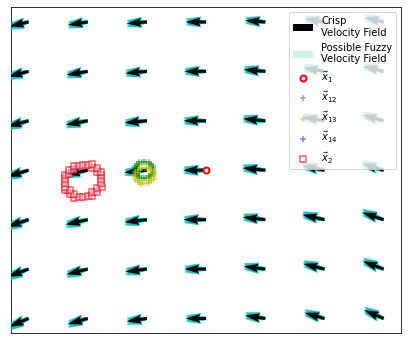

In [34]:
j,i = (20,30)
buff = 3
islice = slice(i-buff,i+buff+1,None)
jslice = slice(j-buff,j+buff+1,None)

xp = grid[1][0,jslice,islice]
yp = grid[2][0,jslice,islice]
up = u[0,jslice,islice]
vp = v[0,jslice,islice]

dt = 2.*np.pi/30.

fig,ax = plt.subplots(figsize=(7,6))
ax.quiver(xp,yp,up,vp,color='k',zorder=1001,label='Crisp\nVelocity Field')
legflag = True
for i in range(uper.shape[0]):
    if legflag:
        ax.quiver(xp,yp,up + uper[i],vp + vper[i],color='c',alpha=0.2,zorder=1000,label='Possible Fuzzy\nVelocity Field')
        legflag = False
    else:
        ax.quiver(xp,yp,up + uper[i],vp + vper[i],color='c',alpha=0.2,zorder=1000)
    
ax.scatter(x1[0],x1[1],marker='o',facecolor='w',edgecolor='r',lw=2,zorder=1003,label=r'$\vec{x}_1$')

k1x = np.array([uint(x1[0],x1[1]) + uper[i] for i in range(uper.shape[0])])
k1y = np.array([vint(x1[0],x1[1]) + vper[i] for i in range(vper.shape[0])])
x12 = np.array([[x1[0],x1[1]] for i in range(uper.shape[0])]) + 0.5*dt*np.column_stack([k1x,k1y])
ax.scatter(x12[:,0],x12[:,1],color='g',marker='+',zorder=1002,alpha=0.5,label=r'$\vec{x}_{12}$')

k2x = uint(x12) + uper
k2y = vint(x12) + vper
x13 = np.array([[x1[0],x1[1]] for i in range(uper.shape[0])]) + 0.5*dt*np.column_stack([k2x,k2y])
ax.scatter(x13[:,0],x13[:,1],color='y',marker='+',zorder=1002,alpha=0.5,label=r'$\vec{x}_{13}$')

k3x = uint(x13) + uper
k3y = vint(x13) + vper
x14 = np.array([[x1[0],x1[1]] for i in range(uper.shape[0])]) + dt*np.column_stack([k3x,k3y])
ax.scatter(x14[:,0],x14[:,1],color='b',marker='+',zorder=1002,alpha=0.5,label=r'$\vec{x}_{14}$')

k4x = uint(x14) + uper
k4y = vint(x14) + vper
x2 = np.array([[x1[0],x1[1]] for i in range(uper.shape[0])]) + (1./6.)*dt*(np.column_stack([k1x,k1y]) + 2.*np.column_stack([k2x,k2y]) + 2.*np.column_stack([k3x,k3y]) + np.column_stack([k4x,k4y]))

ax.scatter(x2[:,0],x2[:,1],marker='s',facecolor='w',edgecolor='r',lw=2,zorder=1003,alpha=0.5,label=r'$\vec{x}_2$')

leg = ax.legend(loc=1)
leg.set_zorder(1004)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig('D:/iCloudDrive/Thesis/Figures/schematix/RK4_illustatration.png',dpi=450)

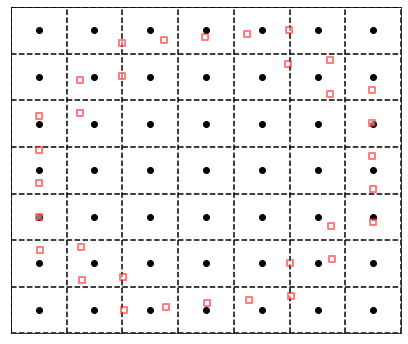

In [43]:
fig,ax = plt.subplots(figsize=(7,6))
ax.set_xticks([])
ax.set_yticks([])

ax.scatter(x2[:,0],x2[:,1],marker='s',facecolor='w',edgecolor='r',lw=2,zorder=1003,alpha=0.5,label=r'$\vec{x}_2$')
x = np.linspace(x2[:,0].min(),x2[:,0].max(),7); dx = np.unique(np.diff(x))[0]
y = np.linspace(x2[:,1].min(),x2[:,1].max(),7); dy = np.unique(np.diff(y))[0]
xx,yy = np.meshgrid(x,y)
ax.scatter(xx,yy,color='k',marker='o',zorder=1001)
for xxx,yyy in zip(np.hstack([x - 0.5*dx,x[-1] + 0.5*dx]),np.hstack([y - 0.5*dy,y[-1] + 0.5*dy])):
    ax.axhline(yyy,color='k',ls='--',zorder=1000)
    ax.axvline(xxx,color='k',ls='--',zorder=1000)
    
ax.set_xlim(x[0] - dx/2.,x[-1] + dx/2.)
ax.set_ylim(y[0] - dy/2.,y[-1] + dy/2.)

plt.savefig('D:/iCloudDrive/Thesis/Figures/schematix/decimate_illustatration.png',dpi=450)

In [57]:
kept_indices = []
for xxx,yyy in zip(xx.ravel(),yy.ravel()):
    ddx = x2[:,0] - xxx
    ddy = x2[:,1] - yyy
    c = np.where(np.logical_and(np.abs(ddx) < 0.5*dx,np.abs(ddy) < 0.5*dy))[0]
    if len(c) > 1:
        d = np.sqrt((x2[c,0] - xxx)**2. + (x2[c,1] - yyy)**2.)
        ckeep = c[d == d.min()][0]
        kept_indices.append(ckeep)
    elif len(c) == 1:
        kept_indices.append(c[0])
    else:
        continue
        
kept_indices = sorted(kept_indices)
uper_hist = uper[kept_indices]
vper_hist = vper[kept_indices]

In [53]:
r = 0.025
theta = np.linspace(0.,2.*np.pi,60)

arr = np.linspace(-r,r,4)
x,y = np.meshgrid(arr,arr)
z = np.zeros_like(x)
for th in theta:
    d = np.sqrt((x - r*np.cos(th))**2. + (y - r*np.sin(th))**2.)
    z[d == d.min()] = 1.
    
uperl = x[z == 1.]
vperl = y[z == 1.]

In [60]:
s = 3
uper_hist = uper_hist[::s]
vper_hist = vper_hist[::s]
uperl = uperl[::s]
vperl = vperl[::s]

C:\Users\hauke\AppData\Local\Temp/ipykernel_16772/2974191804.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xp,yp,spdp,cmap=cm.amp,vmin=0.5,vmax=1.5)


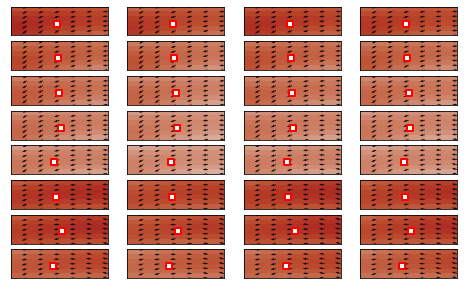

In [76]:
d = np.sqrt((grid[1][0,:,:] - x2[:,0].mean())**2. + (grid[2][0,:,:] - x2[:,1].mean())**2.)
j,i = np.where(d == d.min())
j,i = j[0],i[0]

buff = 3
jslice = slice(j - buff,j + buff + 1,None)
islice = slice(i - buff,i + buff + 1,None)
xp = grid[1][0,jslice,islice]
yp = grid[2][0,jslice,islice]
up = u[0,jslice,islice]
vp = v[0,jslice,islice]

fig,axes = plt.subplots(len(uper_hist),len(uperl),figsize=(8,5))
for j,uh,vh in zip(range(len(uper_hist)),uper_hist,vper_hist):
    for i,ul,vl in zip(range(len(uperl)),uperl,vperl):
        upp = up + uh + ul
        vpp = vp + vh + vl
        spdp = np.sqrt(upp**2. + vpp**2.)
        ax = axes[j,i]
        ax.pcolormesh(xp,yp,spdp,cmap=cm.amp,vmin=0.5,vmax=1.5)
        ax.quiver(xp,yp,upp,vpp)
        ax.scatter(x2[kept_indices,0][j],x2[kept_indices,1][j],marker='s',facecolor='w',edgecolor='r',lw=2)
        ax.set_xticks([])
        ax.set_yticks([])
        
plt.savefig('D:/iCloudDrive/Thesis/Figures/schematix/newVels_illustatration.png',dpi=450)